# Scenario Analysis: Pop Up Shop

![](https://upload.wikimedia.org/wikipedia/commons/thumb/c/c5/Weich_Couture_Alpaca%2C_D%C3%BCsseldorf%2C_December_2020_%2809%29.jpg/1200px-Weich_Couture_Alpaca%2C_D%C3%BCsseldorf%2C_December_2020_%2809%29.jpg)

Kürschner (talk) 17:51, 1 December 2020 (UTC), CC0, via Wikimedia Commons

## The problem

You've been offered an opportunity to operate a pop-up shop to sell a unique commemorative item for each event held at a famous location. The items cost &euro;12 each and you will be able to sell them for 40&euro;. Unsold items can be returned to the supplier but you will receive only &euro;2 due to their commemorative nature.

| Parameter | Symbol | Value |
| :---: | :---: | :---: |
| sales price | $r$ | 40 &euro; |
| unit cost | $c$ | 12 &euro; |
| salvage value | $w$ | 2 &euro; |

The more you sell the more profit you will earn. Demand for these items, however, will be high only if the weather is good. Historical data suggests the following scenarios.

| Scenario ($s$) | Demand ($d_s$) | Probability ($p_s$) |
| :---: | :-----: | :----------: |
| Sunny Skies | 650 | 0.10 |
| Good Weather | 400 | 0.60 |
| Poor Weather | 200 | 0.30 |

Below we create a pandas DataFrame object to store the scenario data.

In [1]:
import numpy as np
import pandas as pd

# price information
r = 40
c = 12
w = 2

# scenario information
scenarios = {
    "sunny skies" : {"prob": 0.10, "demand": 650},
    "good weather": {"prob": 0.60, "demand": 400},
    "poor weather": {"prob": 0.30, "demand": 200},
}

df = pd.DataFrame.from_dict(scenarios).T
display(df)

,prob,demand
sunny skies,0.1,650.0
good weather,0.6,400.0
poor weather,0.3,200.0


The problem is to determine how many items to order for the pop-up shop. The dilemma is that the weather won't be known until after the order is placed. Ordering enough items to meet demand for a good weather day results in a  financial penalty on returned goods if the weather is poor. On the other hand, ordering just enough items to satisfy demand on a poor weather day leaves "money on the table" if the weather is good.

How many items should order for sale at the event?

## Expected value for the mean scenario (EVM)
 
A naive solution to this proc is to place an order equal to the expected demand. The expected demand is given by

\begin{align*}
\mathbb E[D] & = \sum_{s\in S} p_s d_s 
\end{align*}

Choosing an order size $x = \mathbb E[d]$ results in an expected profit we call the **expected value of the mean scenario (EVM)**. 

Given an order size $x$, $y_s$ will be the number of items sold if scenario $s$ should occur. The amount sold is the lesser of the demand $d_s$ and $x$.

\begin{align*}
y_s & = \min(d_s, x) & \forall s \in S
\end{align*}

After completing event, the remaining inventory $x - y_s$ will be sold at the salvage price $w$. Taking into account the revenue from sales $r y_s$, the salvage value of the unsold inventory $w(x - y_s)$, and the cost of the order $c x$, the resulting profit $f_s$ for scenario $s$ is given by

\begin{align*}
f_s & = r y_s + w (x - y_s) - c  x & \forall s \in S
\end{align*}

The average or expected profit is given by

\begin{align*}
\text{EVM} = \mathbb E[f] & = \sum_{s\in S} p_s f_s
\end{align*}

These calculations can be executed using operations on the pandas dataframe. Let's begin by calculating the expected demand.

In [2]:
expected_demand = sum(df["prob"] * df["demand"])
print(f"Expected demand = {expected_demand}")

Expected demand = 365.0


Subsequent calculations can be done directly with pandas dataframe holding the scenario data.

In [3]:
df["order"] = expected_demand
df["sold"] = df[["demand", "order"]].min(axis=1)
df["salvage"] = df["order"] - df["sold"]
df["profit"] = r * df["sold"] + w * df["salvage"] - c * df["order"]

EVM = sum(df["prob"] * df["profit"])

print(f"Mean demand = {expected_demand}")
print(f"Expected value of the mean demand (EVM) = {EVM}")
display(df)

Mean demand = 365.0
Expected value of the mean demand (EVM) = 8339.0


,prob,demand,order,sold,salvage,profit
sunny skies,0.1,650.0,365.0,365.0,0.0,10220.0
good weather,0.6,400.0,365.0,365.0,0.0,10220.0
poor weather,0.3,200.0,365.0,200.0,165.0,3950.0


## Expected value of the stochastic solution (EV)

The optimization problem is to find the order size $x$ that maximizes expected profit subject to operational constraints on the decision variables. The variables $x$ and $y_s$ are non-negative, while $f_s$ can take on both positive and negative values. Operationally, the amount of goods sold in scenario $s$ has to be less than the order size $x$ and customer demand $d_s$. 

The problem to be solved is

$$
\begin{align*}
\text{EV} = & \max_{x, y_s} \mathbb E[F] = \sum_{s\in S} p_s f_s \\
\text{subject to:} \\
f_s & = r y_s + w(x - y_s) - c x & \forall s \in S\\
y_s & \leq x & \forall s \in S \\
y_s & \leq d_s & \forall s \in S
\end{align*}
$$

where $S$ is the set of all scenarios under consideration.

In [4]:
import sys
at_colab = "google.colab" in sys.modules

if at_colab:
    _=!pip install -q pyomo
    _=!wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
    _=!unzip -o -q ipopt-linux64
    _=!apt-get install -y -q coinor-cbc
    _=!pip install -q cplex
    _=!pip install -q gurobipy
    _=!pip install -q xpress

In [80]:
import pyomo.environ as pyo
import pandas as pd

# price information
r = 40
c = 12
w = 2  

# scenario information
scenarios = {
    "sunny skies" : {"demand": 650, "p": 0.1},
    "good weather": {"demand": 400, "p": 0.6},
    "poor weather": {"demand": 200, "p": 0.3},
}

# specify solver
solver = pyo.SolverFactory('cbc')

# create model instance
m = pyo.ConcreteModel('Pet Shop')

# decision variables
m.S = pyo.Set(initialize=scenarios.keys())
m.x = pyo.Var(within=pyo.NonNegativeReals)
m.y = pyo.Var(m.S, within=pyo.NonNegativeReals)
m.f = pyo.Var(m.S)

# objective
m.EV = pyo.Objective(expr=sum([scenarios[s]["p"]*m.f[s] for s in m.S]), sense=pyo.maximize)

# constraints
m.constraints = pyo.ConstraintList()
for s in m.S:
    m.constraints.add(m.f[s] == r*m.y[s] + w*(m.x - m.y[s]) - c*m.x)
    m.constraints.add(m.y[s] <= m.x)
    m.constraints.add(m.y[s] <= scenarios[s]["demand"])

# solve
results = solver.solve(m)

# display solution using Pandas
print("Solver Termination Condition:", results.solver.termination_condition)
print("Expected Profit:", m.EV())
print()
for s in m.S:
    scenarios[s]["order"] = m.x()
    scenarios[s]["sold"] = m.y[s]()
    scenarios[s]["salvage"] = m.x() - m.y[s]()
    scenarios[s]["profit"] = m.f[s]()
    
df = pd.DataFrame.from_dict(scenarios).T
display(df)

Solver Termination Condition: optimal
Expected Profit: 8920.0



,demand,p,order,sold,salvage,profit
sunny skies,650.0,0.1,400.0,400.0,0.0,11200.0
good weather,400.0,0.6,400.0,400.0,0.0,11200.0
poor weather,200.0,0.3,400.0,200.0,200.0,3600.0


FINALIZE NARRATIVE IN BOOK, THEN MATCH TO THE BOOK.

Optimizing the expected value of the profit over all scenarios provides an expected profit of 8,920&euro;, an increase of 581&euro; that is the result of placing a larger order. In poor weather conditions there will be more returns and lower profit, but that is more than compensated by the increased profits in good weather conditions. The value of the stochastic solution is the additional profit compared to ordering to meet expected in demand. In this case,

$$\text{VSS} = \text{EV} - \text{EVM} = 8,920 - 8,339 = 581$$

## Expected value with perfect information (EVPI)

An essential element of the model for maximizing expected profit is the requirement that size of the order be decided before knowing what scenario will unfold. The decision for $x$ has to be made "here and now" with probablistic information about the future, but no specific information which specific future will transpire.

But what if that infomration about the future could be obtained? How much additional profit could be realized if one could travel into the future to determine which scenario will take place, then place today's order accordingly?

To compute the expect profit with perfect information, we will allow the decision varaible $x_s$ to 

$$
\begin{align*}
\text{EVPI} = & \max_{x_s, y_s} \mathbb E[f] = \sum_{s\in S} p_s f_s \\
\text{subject to:} \\
f_s & = r y_s + w(x - y_s) - c x & \forall s \in S\\
y_s & \leq x_s & \forall s \in S \\
y_s & \leq d_s & \forall s \in S
\end{align*}
$$


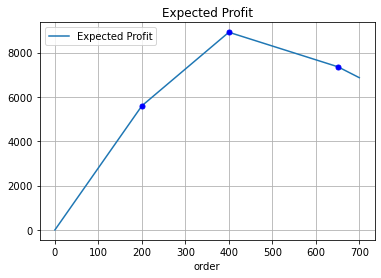

In [367]:
x = np.linspace(0, 700, 701)
ep = pd.DataFrame({"order":x, "Expected Profit": [expected_profit(x) for x in x]})
ax = ep.plot(x="order", title="Expected Profit", grid=True)

for s in df.index:
    x = df.loc[s, "demand"]
    ax.plot(x, expected_profit(x), 'b.', ms=10)
    

We begin by encoding the problem data using Python objects. The scenario information as a pandas DataFrame ... a commonly used technique in Python to store structured data. The set of scenarios is the index to the dataframe.